In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.9.2


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv').fillna( ' ')
train_df.sample(10, random_state=1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
24915,41e65f43c180838e,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1,1,1,0,1,0
75819,cade9e425d75948e,Agent X2: Basically thanks - with a 'little' m...,0,0,0,0,0,0
53891,8ff87747403ed2e6,Why are my posts being deleted? \n\nI have tri...,0,0,0,0,0,0
154159,a95604c7a938abb3,"""\n\n Controlled Demolitions and Common Sense ...",0,0,0,0,0,0
13040,2288910537399728,I do not understand your reply. //Blaxthos ( ...,0,0,0,0,0,0
123190,9309014f225e9975,Is this the bizarro world? Removing content is...,0,0,0,0,0,0
33626,59a295885d985ef1,"Well, WP:RS says that articles should use reli...",0,0,0,0,0,0
1150,031c15507901e54a,Oh hear me go someone removes all my pages i g...,0,0,0,0,0,0
48633,820b548b9acc1ee6,can't believe this article was deleted\nI'm su...,0,0,0,0,0,0
42817,723d53b4406dc45a,"""\n\n Comments on GamerGate Workshop page \n\n...",0,0,0,0,0,0


In [4]:
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [5]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


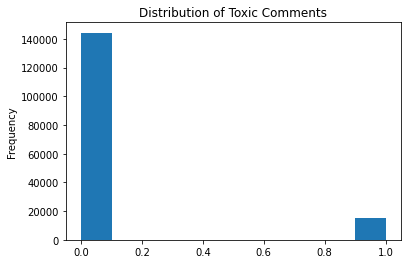

In [6]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments');

# Data Prep - Tokenize and Pad Text Data

In [7]:
max_features = 20000
max_text_length = 400

In [8]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x) 
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)
#pad_sequences:transform a list of num_samples sequences (lists of scalars) into a 2D Numpy array of shape 

# Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2022-12-19 23:05:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-19 23:05:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-19 23:05:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
embedding_dims = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_features, embedding_dims))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

# Create Embedding Layer

In [14]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

Build model...


# Build the Model

In [15]:
filters = 250
kernel_size = 3
hidden_dims = 250


In [16]:
# add a Convolution1D, which will learn filters
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
# use max pooling:
model.add(GlobalMaxPooling1D())
# add a vanilla hidden layer:
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

# I project onto 6 output layers, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         75250     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 250)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 250)         312750    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                         

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train Model

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1)

We'll fit the model with train data then will check the training accuracy.

In [19]:
batch_size = 32
epochs = 3

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Epoch 1/3
4239/4239 [==============================] - 3033s 715ms/step - loss: 0.1480 - accuracy: 0.9463 - val_loss: 0.1301 - val_accuracy: 0.9572
Epoch 2/3
4239/4239 [==============================] - 3010s 710ms/step - loss: 0.1212 - accuracy: 0.9559 - val_loss: 0.1171 - val_accuracy: 0.9600
Epoch 3/3
3622/4239 [========================>.....] - ETA: 6:57 - loss: 0.1106 - accuracy: 0.9597

In [54]:
acc =model.evaluate(x_train, y_train)
print("Loss:", acc[0], " Accuracy:", acc[1])

4239/4239 [==============================] - 889s 210ms/step - loss: 0.0903 - accuracy: 0.9652
Loss: 0.0902857780456543  Accuracy: 0.9652228355407715


# Evaluate Model

testing Loss, Accuracy

In [25]:
model.evaluate(x_val, y_val, batch_size=128)

187/187 [==============================] - 144s 769ms/step - loss: 0.1101 - accuracy: 0.9593


[0.1100631058216095, 0.9592663645744324]

In [26]:
test_df = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

In [27]:
x_test = test_df['comment_text'].values

In [28]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

predict test values

In [29]:
y_testing = model.predict(x_testing, verbose = 1, batch_size=32)

4787/4787 [==============================] - 979s 204ms/step


In [47]:
y_testing

array([[9.6367759e-01],
       [2.2098708e-03],
       [1.6810937e-03],
       ...,
       [6.6174958e-05],
       [3.6890531e-04],
       [9.7235674e-01]], dtype=float32)

In [30]:
y_testing.shape

(153164, 1)

In [31]:
y_testing[0]

array([0.9636776], dtype=float32)

In [32]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text', 'Toxic']].head(20)#.sample(20, random_state=1)

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
